### Tanh
##### All the parameters are set in the block "*Specifying the input parametes*" any changes to be made are to changed here 
NOTE : Model is designed for the baseline model as given in the assignment , any addition or deletion of the layers are to be done \
please change the codes in the relevant blocks \
LINEAR -> TANH -> LINEAR -> TANH -> LINEAR -> TANH -> LINEAR -> SOFTMAX \
[I/P , 500 ,250,100, O/P]

##### Importing Libraries

In [1]:
## Importing Libraries 
#The dataset of the MNIST Digit is obtained from the Dataloader function of the pytorch
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torchvision
import torchvision.transforms as transforms

In [2]:
print(torch.__version__)

1.12.1


##### Specifying the input parameters

In [3]:
input_size = 784 # 28x28
hidden_layer1= 500 
hidden_layer2=250
hidden_layer3=100
num_classes = 10
numEpochs = 15
batch_Size = 64
learning_rate = 0.01


##### Loading the Dataset(Test and Train)

In [4]:

#Loading the dataset from the Torch Vision Libraires 
"""#arguments passed are
root =  location of the dataset where it is to be downloaded 
train -> a bool argument is set to true if you are downloading the train dataset and False if you are downloading the Test Dataset 
transform ->ToTensor converts a PIL image or NumPy ndarray into a FloatTensor. and scales the image’s pixel intensity values in the range [0., 1.]
Download is a Bool values set to True to download the dataset"""
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(),  download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

##### Look up for the distribution of the data 

Train labels:  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
60000


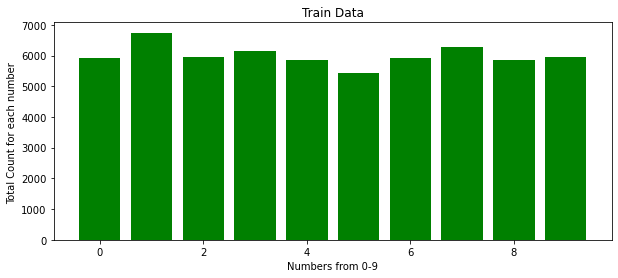

In [5]:
# To check the data of the x_train is equally distributed or not 
# in case of unequal distribution of the data or skewed distribution , we need to apply certain data preprocessing steps 
# so that the model does not skew/ be oriented to a class of dataset but equally learn all the classes 
loader_train = torch.utils.data.DataLoader(dataset=train_dataset,batch_size = 60000 ,shuffle=True)  # Dataloder with shuffling and batchsize mentioned 
dataiter = iter(loader_train)   # iter is the function to iterate through the entire dataset
data = next(dataiter)       #Python built-in next() function to get the next data element in the stream of data
X_train,y_train = data

X_train=X_train.numpy()      # Convertibg the tensors to numpy 
y_train=y_train.numpy()          

unique, counts = np.unique(y_train, return_counts=True)      # Using the numpy unique function to see the distribution of the each class of digit 
print("Train labels: ", dict(zip(unique, counts)))               
print(np.sum(counts))                                   
fig = plt.subplots(figsize =(10, 4))
plt.bar(unique,counts,color ='green',width=0.8)                      # plotting the Bar graph 
plt.xlabel("Numbers from 0-9")
plt.ylabel("Total Count for each number ")
plt.title("Train Data")
plt.show()


Train labels:  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}
10000


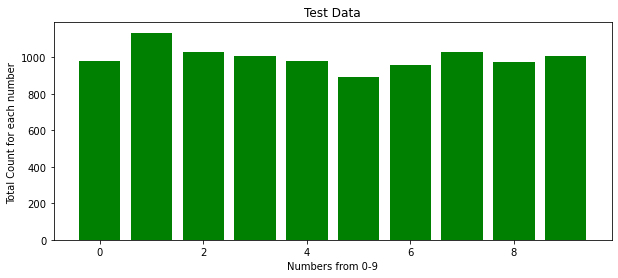

In [6]:
#Similar to the train , checked the test dataset to see the distribution , so that one can compare the numbers 
# distributed in the each label 
# All the functions are same as used in the above test case
loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size = 10000 ,shuffle=True)
dataiter = iter(loader)
data = next(dataiter)
X_test,y_test = data

X_test=X_test.numpy()
y_test=y_test.numpy()
unique, counts = np.unique(y_test, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))
print(np.sum(counts))
fig = plt.subplots(figsize =(10, 4))
plt.bar(unique,counts,color ='green',width=0.8)
plt.xlabel("Numbers from 0-9")
plt.ylabel("Total Count for each number ")
plt.title("Test Data")
plt.show()


##### One hot encoding

In [7]:
"""Converting the y or the label from number to array sequences 
using the one hot encode
if the label has the class [5] we need to convert it as [0,0,0,0,0,1,0,0,0,0]
"""
def convert_to_onehot(labels,num_classes):            
    output = np.eye(num_classes)[np.array(labels).reshape(-1)]                        # An array where all elements are equal to zero, except for the k-th diagonal, whose values are equal to one.
    return output.reshape(list(np.shape(labels))+[num_classes])                       # reshaping the above sequences as required for the input in the code

##### Activation function and their derivatives

In [8]:
# Activation Functions 
# these are the activation function we will be using in the forward pass 
def sigmoid(x): 
    return 1/(1+np.exp(-x))            

def relu(x):
    return np.maximum(0, x)

def softmax(x):
    return np.exp(x)/sum(np.exp(x))

def tanh(x):
    t=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    return t

In [9]:
#Derivatives of the activation function 
# used in the back propogation algorithm

def sigmoid_derivative(x):
    return sigmoid(x) * (1- sigmoid(x))

def relu_derivative(x):
    return x>0

def tanh_derivative(x):
    return 1-(tanh(x)**2)

##### Initialization

In [10]:
#Initialization
#Glorot /Xavier Initialization for the weights and zero initialization for the biases 
# No is the out layer 
# Ni is the in layer 
#Picking up a random sample from the uniform distribution of the [-M,M]
def init_weights(No,Ni):
    M=np.sqrt(6/(Ni+No))
    weights=np.asarray(np.random.uniform(-M, M, (No, Ni)), dtype=np.float64)
    biases  = np.zeros((No,1))
    return weights,biases

In [11]:
# Weight and biases initialization  initialization 
# Given format of the layer dimension are [i/p -> 500 ->250 -> 100-> o/p]
# All the shape of the weight and biases are written down in the documentation 
# all the required parameters are stored in as a dictionary and are called in the next steps 
# the function returns the parameter (dictionary of the weights and biases)
# Caution !! Note and remember to call them in the same order as they are defined here , else you might end up in making a blunder
def initialize_parameters(layers_dims):
    W1,b1=init_weights(layers_dims[1],layers_dims[0])
    W2,b2=init_weights(layers_dims[2],layers_dims[1])
    W3,b3=init_weights(layers_dims[3],layers_dims[2])
    W4,b4=init_weights(layers_dims[4],layers_dims[3])
    parameters={ "W1":W1,"W2":W2,"W3":W3,"W4":W4,
                 "b1":b1,"b2":b2,"b3":b3,"b4":b4}
    return parameters  

##### Forward Propogation

In [12]:
# Forward Propogation 
# Function take the input vector X as the arugment and the initialized parameters dictionary as the other 
# X input dataset of the size (features , number of samples )
# Parameters are from the dicrionary W1...W4, b1...b4
"""Returns:
A4 -- the output of the sigmoid function 
cache --  a dicrionary containing all the parameters that can be used in the next step 
"""
#call the dictionary parameters 
def forward_propagation(X,parameters):
    W1=parameters["W1"]
    b1=parameters["b1"]
    W2=parameters["W2"]
    b2=parameters["b2"]
    W3=parameters["W3"]
    b3=parameters["b3"]
    W4=parameters["W4"]
    b4=parameters["b4"]
    Z1=np.dot(W1,X.T)+b1
    A1=tanh(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2=tanh(Z2)
    Z3 = np.dot(W3,A2) + b3
    A3=tanh(Z3)
    Z4=np.dot(W4,A3)+b4
    A4=softmax(Z4)

    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3 , Z4 ,A4 , W4 , b4)

    return A4,cache

##### Computing Loss (Cross entropy)

In [13]:
# Calculating the loss function using the cross entropy
"""Arguments:
    A -- post-activation, output of forward propagation
    Y -- "true" labels vector, same shape as A

    Returns:
    cost - value of the cost function
"""
def compute_cost(A, Y):    
    #A is predicted
    #Y is actual
    m = Y.shape[1] 
    logprobs = np.multiply(-np.log(A),Y) + np.multiply(-np.log(1 - A), 1 - Y)
    cost = 1./m * np.nansum(logprobs)
    return cost

#### Backward Propogation

In [14]:
"""
    Implement the backward propagation presented in figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    cache -- cache output from forward_propagation()
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
"""
def backward_propagation(X, Y, cache):

    m = X.shape[1]

    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3 , Z4 ,A4 , W4 , b4) = cache
    dZ4 = A4 - Y
    dW4 = 1./m * np.dot(dZ4, A3.T)
    db4 = 1./m * np.sum(dZ4, axis=1, keepdims = True)
    
    dA3 = np.dot(W4.T, dZ4)
    dZ3 = np.multiply(dA3, tanh_derivative(Z3))
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, tanh_derivative(Z2))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, tanh_derivative(Z1))
    dW1 = 1./m * np.dot(dZ1, X)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)

    
    gradients = {"dZ4": dZ4, "dW4": dW4, "db4": db4,
                 "dA3": dA3, "dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

##### Updating the parameters with GD

In [15]:
#Update the parameters after the back prop using the gradient descent algo
"""
    
    Arguments:
    parameters - which are defined after the initializations , W1...W4 , b1...b4 
    gradients  - terms found after the backprop and stored in the dictionary of the gradients 
    learning_rate - using the value of alpha/eta as given by the user to learn the parameters
    
    Returns:
    updated parameters - a dictionary for the new set of values for the W's and b's after the updation rule is performed
"""
def update_parameter(parameters,gradients,learning_rate):

    
    W1=parameters["W1"]
    b1=parameters["b1"]
    W2=parameters["W2"]
    b2=parameters["b2"]
    W3=parameters["W3"]
    b3=parameters["b3"]
    W4=parameters["W4"]
    b4=parameters["b4"]
    dW1=gradients["dW1"]
    db1=gradients["db1"]
    dW2=gradients["dW2"]
    db2=gradients["db2"]
    dW3=gradients["dW3"]
    db3=gradients["db3"]
    dW4=gradients["dW4"]
    db4=gradients["db4"]
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3
    W4 -= learning_rate * dW4
    b4 -= learning_rate * db4
    
    updated_parameters={"W1":W1,"W2":W2,"W3":W3,"W4":W4,
                        "b1":b1,"b2":b2,"b3":b3,"b4":b4}

                        
    return updated_parameters

##### Statistical Inference Function

In [16]:
#Finding the accuracy of the parameter at the output 
"""  
    Arguments:
    y_actual -  given in the dataset / also called as the ground truth 
    y_pred - generated from the neural network , after a series of forward and backprop 
    
    Returns:
    accuracy =  finding the matches of the prdicted vs the actual
"""
def find_accuracy(y_actual,y_pred):
    accuracy = np.count_nonzero(np.argmax(y_pred,axis=0)==np.argmax(y_actual,axis=1))/y_actual.shape[0]
    return accuracy

In [17]:
def predict(X,Y,parameters):

    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    Y -- data set of examples
    parameters -- parameters of the trained model
    
    Returns:
    ypred -- predictions for the given dataset X
    """

    y_pred,cache=forward_propagation(X,parameters)
    return y_pred

##### Model Training 

In [18]:
def model(dataset,layers_dims,numEpochs):
    """
    Function model takes in the arguments :
    dataset -> train dataset which is size of 60000
    layer_dim -> takes the dimension of the neural net we are giving in (base line in our case)
    numEpochs -> the entire data seen in one iteration ,15 in our case

    Returns :
    accuracy of the model 
    cost in each iteration 
    parameters that are needed to test the data for the test dataset and train dataset
    """
    k=len(dataset)                               #length of the dataset
    numBatches=k/batch_Size                      # number of batches = 60000/64 = 937
    parameters=initialize_parameters(layers_dims)     # initializing the parameters
    costs=[]                                          #cost accumulation
    acc=[]                                            #accuracy 
    for epoch in range(numEpochs):
        for ii in range(int(numBatches)):
            # Data loader
            loader = torch.utils.data.DataLoader(dataset=dataset,batch_size = batch_Size ,shuffle=True)      
            dataiter = iter(loader)
            data = next(dataiter)
            X,y = data
            X=X.numpy()
            y=y.numpy()
            
            image_vector_size = 28*28
            X = X.reshape(X.shape[0], image_vector_size)    #image is already flattened to x/255
            y_one_hot=convert_to_onehot(y,num_classes)
            y_pred,cache=forward_propagation(X,parameters)
            cost=compute_cost(y_pred,y_one_hot.T)
            gradients=backward_propagation(X,y_one_hot.T,cache)
            parameters=update_parameter(parameters,gradients,learning_rate)
            if ii%200 ==0:
                print (f'Epoch [{epoch+1}/{numEpochs}], Step [{ii+1}/{int(numBatches)}], Loss: {cost.item():.4f}')
            acc.append(find_accuracy(y_one_hot,y_pred))
            costs.append(cost)
    return acc,costs,parameters



In [19]:
layers_dims=[784,500,250,100,10]
train_acc,train_costs,trained_parameters=model(train_dataset,layers_dims,numEpochs)

Epoch [1/15], Step [1/937], Loss: 3.3623
Epoch [1/15], Step [201/937], Loss: 2.6494
Epoch [1/15], Step [401/937], Loss: 2.3156
Epoch [1/15], Step [601/937], Loss: 2.1788
Epoch [1/15], Step [801/937], Loss: 1.8405
Epoch [2/15], Step [1/937], Loss: 1.5767
Epoch [2/15], Step [201/937], Loss: 1.6039
Epoch [2/15], Step [401/937], Loss: 1.4741
Epoch [2/15], Step [601/937], Loss: 1.2324
Epoch [2/15], Step [801/937], Loss: 1.2994
Epoch [3/15], Step [1/937], Loss: 1.1319
Epoch [3/15], Step [201/937], Loss: 1.1713
Epoch [3/15], Step [401/937], Loss: 0.7894
Epoch [3/15], Step [601/937], Loss: 1.0663
Epoch [3/15], Step [801/937], Loss: 1.1085
Epoch [4/15], Step [1/937], Loss: 1.1113
Epoch [4/15], Step [201/937], Loss: 0.9614
Epoch [4/15], Step [401/937], Loss: 1.1456
Epoch [4/15], Step [601/937], Loss: 0.9772
Epoch [4/15], Step [801/937], Loss: 1.0546
Epoch [5/15], Step [1/937], Loss: 0.8144
Epoch [5/15], Step [201/937], Loss: 0.7527
Epoch [5/15], Step [401/937], Loss: 1.1395
Epoch [5/15], Step [6

In [20]:
print((train_costs[-1]))

0.8034346921669954


In [21]:
print((train_acc[-1]))

0.859375


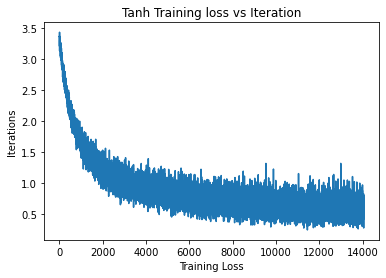

In [22]:
plt.plot(train_costs)
plt.xlabel('Training Loss')
plt.ylabel('Iterations')
plt.title("Tanh Training loss vs Iteration")
plt.show()

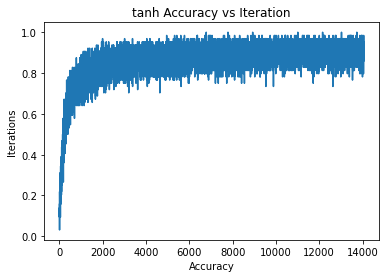

In [23]:
plt.plot(train_acc)
plt.xlabel('Accuracy')
plt.ylabel('Iterations')
plt.title("tanh Accuracy vs Iteration")
plt.show()

##### Model Testing 

In [24]:
p=len(test_dataset)
test_batches=p/batch_Size
numBatches=p/batch_Size
# test_costs=[]
# test_accuracy=[]
# for i in range(int(test_batches)):
loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size = p ,shuffle=True)
dataiter = iter(loader)
data = next(dataiter)
X,y = data
X=X.numpy()
y=y.numpy()
# Flatten the images
image_vector_size = 28*28
X = X.reshape(X.shape[0], image_vector_size)
y_one_hot=convert_to_onehot(y,num_classes)
y_hat,out_cache=forward_propagation(X,trained_parameters)
#     test_costs.append(compute_cost(y_hat,y_one_hot.T))
#     test_accuracy.append(find_accuracy(y_one_hot,y_hat))
test_accracy=find_accuracy(y_one_hot,y_hat)
(compute_cost(y_hat,y_one_hot.T))

        

0.5588192259688277

In [25]:
k = np.argmax(y_hat,axis=0)


Train labels:  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


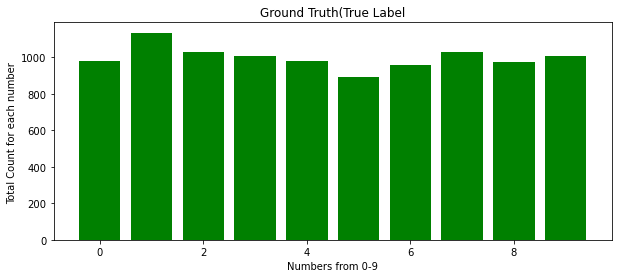

In [26]:
unique, counts = np.unique(y, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))
np.sum(counts)
fig = plt.subplots(figsize =(10, 4))
plt.bar(unique,counts,color ='green',width=0.8)
plt.xlabel("Numbers from 0-9")
plt.ylabel("Total Count for each number ")
plt.title("Ground Truth(True Label")
plt.show()


In [27]:
unique, counts = np.unique(k, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))
np.sum(counts)

Train labels:  {0: 1031, 1: 1146, 2: 997, 3: 1014, 4: 1014, 5: 834, 6: 973, 7: 1022, 8: 973, 9: 996}


10000

#### Results

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix(k, y)

/home/koushikbhat/anaconda3/envs/DLI/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


array([[ 961,    0,   12,    3,    1,   16,   13,    4,   10,   11],
       [   0, 1102,    8,    0,    1,    3,    3,   14,    8,    7],
       [   2,    3,  910,   24,    2,    6,    7,   28,   11,    4],
       [   2,    4,   13,  903,    1,   48,    2,    7,   25,    9],
       [   0,    1,   14,    0,  910,   12,   15,    6,    8,   48],
       [   3,    0,    1,   34,    0,  743,   12,    0,   28,   13],
       [   7,    3,   14,    2,   17,   13,  901,    0,   15,    1],
       [   1,    2,   17,   18,    2,    8,    1,  934,   14,   25],
       [   4,   20,   35,   19,    7,   33,    4,    3,  843,    5],
       [   0,    0,    8,    7,   41,   10,    0,   32,   12,  886]])

Text(51.0, 0.5, 'truth')

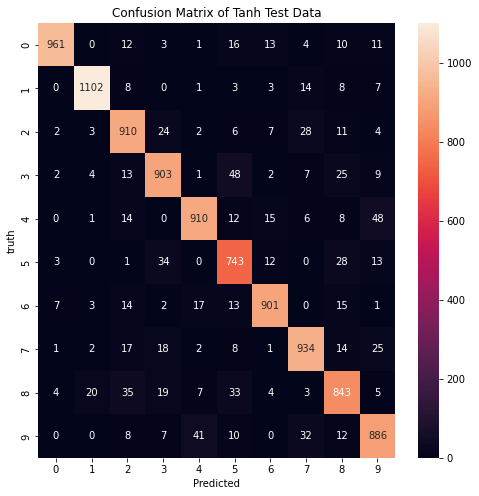

In [29]:
import seaborn as sn
plt.figure(figsize=(8,8))
sn.heatmap(confusion_matrix(k, y),annot=True,fmt='d')
plt.title('Confusion Matrix of Tanh Test Data')
plt.xlabel('Predicted')
plt.ylabel('truth')

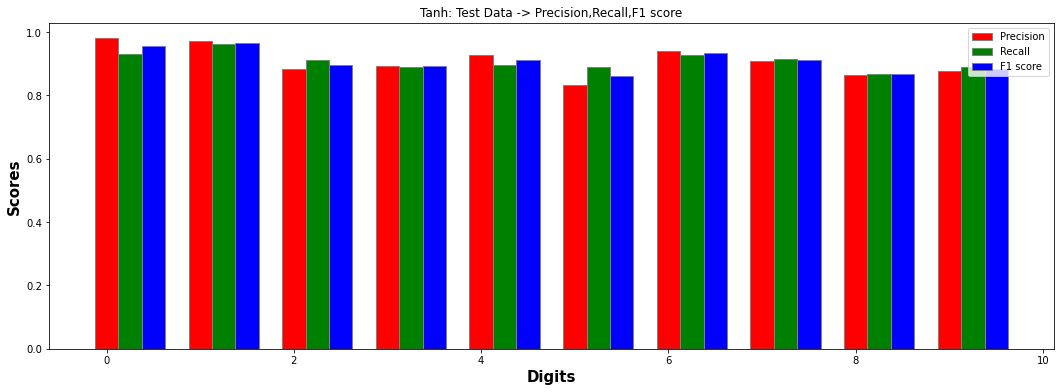

In [30]:
precision = np.diag(confusion_matrix(k, y))/np.sum(confusion_matrix(k, y),axis=0)
recall = np.diag(confusion_matrix(k, y))/np.sum(confusion_matrix(k, y),axis=1)
f1_score = 2*precision*recall/(precision+recall)

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(18, 6))
br1 = [0,1,2,3,4,5,6,7,8,9]
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.bar(br1, precision, color ='r', width = barWidth,
        edgecolor ='grey', label ='Precision')
plt.bar(br2, recall, color ='g', width = barWidth,
        edgecolor ='grey', label ='Recall')
plt.bar(br3, f1_score, color ='b', width = barWidth,
        edgecolor ='grey', label ='F1 score')
plt.xlabel('Digits', fontweight ='bold', fontsize = 15)
plt.ylabel('Scores', fontweight ='bold', fontsize = 15)
plt.title('Tanh: Test Data -> Precision,Recall,F1 score')
plt.legend()
plt.show()

In [31]:
print("Accuracy of the training model:",train_acc[-1])


Accuracy of the training model: 0.859375


In [32]:
print("Test Accuracy of the Model",test_accracy)

Test Accuracy of the Model 0.9093
